In [1]:
# prerequisites
import os
import torch
import time
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils import *
from models import MNIST_SITE

# Device configuration
torch.manual_seed(0)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 256
model_path = './models/MNIST'
n_epoch = 200
n_show = 1

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=False)

In [3]:
site = MNIST_SITE().to(device)
print(f'Models are properly built! There are totally {get_n_params(site)} parameters.')

optimizer = optim.Adam(site.parameters(), lr = 1e-3)

celoss = nn.CrossEntropyLoss()
bceloss = nn.BCELoss()

Models are properly built! There are totally 1365472 parameters.


235it [00:14, 16.53it/s]


epoch: 1, loss: 1.231/7.446, train_acc: 0.6122, test_acc: 0.8243, time: 15.77


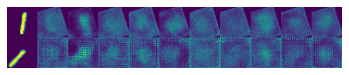

235it [00:12, 18.11it/s]


epoch: 2, loss: 0.519/6.379, train_acc: 0.8428, test_acc: 0.8739, time: 14.53


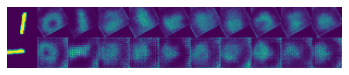

86it [00:05, 14.66it/s]

In [ ]:
for epoch in range(n_epoch):
    Loss_cls = []
    Loss_rec = []
    Loss_tar = []
    equality = 0
    start = time.time()
    
    # generate new prototypes
    prototype = get_prototype(train_loader)
    
    for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
        
        site.train()
        
        optimizer.zero_grad()
        
        image = image.to(device)
        label = label.to(device)
        
        theta, gamma = get_theta(image.shape[0], get_reverse = True)
        t_image = transform(image, theta, dataset = 'MNIST')
        
        t_W, t_pred = site.get_explanation(t_image)
        t_W_t = transform_W(t_W, gamma, dataset = 'MNIST')
        
        # Classification loss
        loss_cls = celoss(t_pred, label)
        Loss_cls.append(loss_cls.item())
        
        # Reconstruction loss
        target = sample_prototype(prototype, label)
        loss_rec = 10*bceloss(t_W_t, target)
        Loss_rec.append(loss_rec.item())
        
        loss = loss_cls + loss_rec
        loss.backward()
        optimizer.step()
        
        equality += (t_pred.max(1)[1] == label).float().mean()
    
    train_accuracy = equality / (batch_idx + 1)
    
    equality = 0
    for batch_idx, (image, label) in enumerate(test_loader):
        
        site.eval()
        
        image = image.to(device)
        label = label.to(device)
        
        theta, gamma = get_theta(image.shape[0], get_reverse = True)
        t_image = transform(image, theta, dataset = 'MNIST')
        
        t_W, t_pred = site.get_explanation(t_image)

        equality += (t_pred.max(1)[1] == label).float().mean()
        
    test_accuracy = equality / (batch_idx + 1)
    
    print('epoch: {}, loss: {:.3f}/{:.3f}, train_acc: {:.4f}, test_acc: {:.4f}, time: {:.2f}'.format(
        epoch + 1,
        torch.FloatTensor(Loss_cls).mean(),
        torch.FloatTensor(Loss_rec).mean(),
        train_accuracy,
        test_accuracy,
        time.time() - start))
    
    if n_epoch % n_show == 0:
        toshow1 = torch.cat([image[0], t_W_t[0].view(10,28,28)], dim = 0)
        toshow2 = torch.cat([t_image[0], t_W[0]], dim = 0)
        toshow = torch.cat([toshow1, toshow2], dim = 1)
        plot_process(toshow)